In [1]:
!pip install lmfit

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import lmfit
import datetime
from datetime import date
from sklearn import linear_model
import datetime
import argparse
pd.options.mode.chained_assignment = None  # default='warn'

#---------------Please adjust variables here or in the command line------------------------------------------------------------
data_path='C:\\Users\\Bringer\\Documents\\JADS\\Aa-en-Maas\\Features\\' #(--data_path)
weir='211B_211C' #(--weir)
risk_date='2021-04-01' # (--risk_date)
prediction=False # True for prediction (--prediction)
last_days=7 # (--last_days) For prediction: Defines how many days the linear model takes into account to predict the next 21 days
avg_temp=22 # (--avg_temp) For prediction: Average Temperature adjusts the prediction +/- 20%
#---------------End of adjust variables-------------------------------------------------------------------------------------------

# From now on PLEASE DO NOT CHANGE------------------------------------------------------------------------------------------------

def get_data(weir,data_path,date_format=False):
    ''' Get the feature data of the individual weir
    Keyword arguments:
    weir -- the weir name as string
    date_format -- date_format boolean 
    data_path -- the local path of the weir feature data csv's
    Returns: data as dataframe'''
    datapath=data_path+weir+'_feature_table.csv'
    data=pd.read_csv(datapath,index_col="TIME",parse_dates=True)
    if date_format:
        data.index=data.index.strftime('%Y-%m-%d')
    return data
    
def get_model(weir:str,year:int,data_path):
    '''Get the model Aa-en-Maas uses to define the backwater caused in winter
    Keyword arguments:
    weir -- the weir name as string
    year -- year as int
    data_path -- the local path of the weir feature data csv's
    Returns: model'''
    weir_data=get_data(weir,data_path,date_format=True)
    selected_data=weir_data[['VERSCHIL', 'Q']]
    # Set values of Verschil lower than 0 to 0 as backwater cannot be negative
    selected_data['VERSCHIL']=negative_backwater_to_zero(selected_data['VERSCHIL'])
    # Set the Q value also to 0 where backwater is now 0
    selected_data.loc[(selected_data.VERSCHIL == 0),'Q']=0
    # Winter season where plants are "not" growing from 1st October to end of February
    winter_data=selected_data.loc[str(year-1)+'-10-01':str(year)+'-02-31']
    # The polynomial function Aa-en-Maas currently uses
    def eqn_poly(x, a, b):
        ''' simple polynomial function'''
        return  a*(x**b)     
    mod = lmfit.Model(eqn_poly)
    lm_result = mod.fit(np.array(winter_data['VERSCHIL']), x=np.array(winter_data['Q']), a=1.0, b=1.0)
    return lm_result
    
def negative_backwater_to_zero(vegetation_data):
    '''Set values lower than 0 to 0 as backwater cannot be negative'''
    return np.clip(vegetation_data, 0, None)
    
def calc_vegetation(weir,weir_data,risk_date,data_path):
    '''Calculate the back water caused by plants of a single data point
    Keyword arguments:
    weir -- the weir name as string
    weir_data -- the feature data of the weir
    risk_date -- the date where the vegetation risk should be evaluated on
    data_path -- the local path of the weir feature data csv's
    Returns: current vegetation '''
    try:
        # Take the necessary features(VERSCHIL and Q) of the data at the given date
        risk_date_data=weir_data[['VERSCHIL', 'Q']].loc[risk_date]
    except:
        print('This date is not in the database')
    risk_date=datetime.datetime.strptime(risk_date, "%Y-%m-%d")
    current_year=risk_date.year
    try:
        #Get the winter baseline model of the current year
        model=get_model(weir,year=current_year,data_path=data_path)
    except:
        print('Error, model cannot be created for year {}'.format(current_year))
        return 0
    # If the date is in the winter period, 
    if ((risk_date.month <= 2) | (risk_date.month >= 10)):
        # the back water is assumed to be 0 as the plants do "not" grow in winter
        current_vegetation = 0
    elif (risk_date_data.empty):
        print("No flow data for "+ weir+ " on date ", risk_date)
        current_vegetation = None
    elif (len(risk_date_data) == 0):
        print("No data for ", weir, " on date ", risk_date)
        current_vegetation = None
    else:
        # Predict the vegetation for every summer data point based on the winter baseline
        winter_pred = model.eval(x=risk_date_data['Q'])
        winter_pred=negative_backwater_to_zero(winter_pred)
        # Calculate the vegetation by plants: Current back water - predicted back water based on winter
        current_vegetation= risk_date_data.loc["VERSCHIL"] - winter_pred
        current_vegetation=negative_backwater_to_zero(current_vegetation)
    return current_vegetation   
    
def calc_vegetation_risk(weir,risk_date, data_path):
    ''' Calculate the vegetation risk between 1 and 4
    Keyword arguments:
    weir -- the weir name as string
    risk_date -- the date where the vegetation risk should be evaluated on
    data_path -- the local path of the weir feature data csv's
    Returns: Risk category, Quantiles of vegetation 25,50,75'''
    weir_data=get_data(weir,date_format=True,data_path=data_path)
    # Calculate the back water by plants on given date
    current_vegetation=calc_vegetation(weir,weir_data,risk_date,data_path)
    risk_date=datetime.datetime.strptime(risk_date, "%Y-%m-%d")
    current_year=risk_date.year
    min_year=current_year - 3
    total_vegetation=[]
    # Get the vegetation for the last three years
    for year in range(min_year,current_year):
        try: 
            # load model of given year
            model_year =get_model(weir, year=year,data_path=data_path)
        except:
            print('Error,year '+str(year)+' model cannot be created')  
            continue
        # Select summer season data from March till end of September
        summer_data = weir_data.loc[str(year)+'-03-01':str(year)+'-09-31']
        # Predict the vegetation for every summer data point based on the winter baseline
        winter_pred = model_year.eval(x=summer_data['Q']) 
        winter_pred=negative_backwater_to_zero(winter_pred)
        # Calculate the vegetation by plants: Current back water - predicted back water based on winter
        vegetation_year=summer_data.loc[:,"VERSCHIL"]-winter_pred
        vegetation_year=negative_backwater_to_zero(vegetation_year)
        total_vegetation.append(vegetation_year)
    total_vegetation = pd.concat(total_vegetation)
    # Get Quantiles of the total vegetation
    vegetation_q25=np.quantile(total_vegetation,0.25)
    vegetation_q50=np.quantile(total_vegetation,0.50)
    vegetation_q75=np.quantile(total_vegetation,0.75)
    # Get Risk category based on quantile segment
    risk_cat=np.where(current_vegetation > vegetation_q75,4,np.where(current_vegetation > vegetation_q50,3,np.where(current_vegetation > vegetation_q25,2,1))).tolist()
    # Return risk category and the quantiles
    print("The risk category for the date: {} is {}. The following quantiles were used for the risk calculation 0.25:{}, 0.5:{}, 0.75:{}".format(risk_date,risk_cat,vegetation_q25, vegetation_q50, vegetation_q75))
    return [risk_cat,vegetation_q25, vegetation_q50, vegetation_q75]
    
def predict_vegetation(weir,last_days,avg_temp,data_path):
    '''Predict the vegetation of the next 21 days based on the last 7 days with linear model
    Keyword arguments:
    weir -- the weir name as string
    last_days -- the number of days the linear model should base the prediction on
    avg_temp -- the average temperature adjusting the predictions by +/- 20%
    data_path -- the local path of the weir feature data csv's
    Returns: Dataframe of the backwater predictions of the next 21 days'''
    data=get_data(weir,data_path,date_format=True)
    data.reset_index(inplace=True)
    # Get the last data points depending on number of last_days
    last_data=data.tail(last_days)
    # Get last day to calculate 
    last_day = datetime.datetime.strptime(last_data.iloc[-1]['index'], "%Y-%m-%d")
    # Get dates of the next 21 days
    new_dates=[last_day+datetime.timedelta(days=i) for i in range(1,22)]
    # Calculate back water by vegetation for the last days
    last_data['vegetation']=last_data['index'].apply(lambda row:calc_vegetation(weir,get_data(weir,data_path,date_format=True),row,data_path))
    last_data.reset_index(inplace=True)
    # Define linear model
    reg = linear_model.LinearRegression()
    # Take index and the back water by vegetation as training data
    x_train=last_data.index.to_numpy().reshape(-1, 1)
    y_train=last_data['vegetation'].to_numpy().reshape(-1, 1)
    # Fit the linear model on the last days
    reg.fit(x_train,y_train)
    # Get index for the next 21 days
    x_test=[x_train[-1]+i for i in range(1,22)]
    # Predict the vegetation for the next 21 days
    predictions=reg.predict(x_test)
    # Format
    predictions= [item for elem in predictions.tolist() for item in elem]
    # Depending on the temperature add multplication value to adjust values
    try:
        if (avg_temp > 25):
            predictions=[pred*1.2 for pred in predictions]
        elif (avg_temp<20):
            predictions=[pred*0.8 for pred in predictions]
    except:
        print("The Temperature was not available")
    data = {'index':  new_dates,'Predicted backwater by vegetation': predictions}
    df = pd.DataFrame (data, columns = ['index','Predicted backwater by vegetation'])
    print(df)
    return df
    
def main():
    parser = argparse.ArgumentParser(description='Arguments get parsed via --commands')
    parser.add_argument('--weir', type=str,default=weir)
    parser.add_argument('--risk_date', type=str, default=risk_date)
    parser.add_argument('--data_path', type=str,default=data_path)
    parser.add_argument('--prediction', type=bool,default=prediction)
    parser.add_argument('--last_days', type=int,default=last_days)
    parser.add_argument('--avg_temp', type=int,default=avg_temp)
    args = parser.parse_args([])
    if args.prediction:
        predict_vegetation(weir=args.weir,last_days=args.last_days,avg_temp=args.avg_temp,data_path=args.data_path)
    else:
        calc_vegetation_risk(weir=args.weir,risk_date=args.risk_date, data_path=args.data_path)
    
#if __name__ == '__main__':
#    main()

In [4]:
data_path='C:\\Users\\20193727\\Downloads\\data_for_students\\data\\feature_tables\\' #(--data_path)
weir='211N_211M' #(--weir)
risk_date='2021-04-28' # (--risk_date)
prediction=True # True for prediction (--prediction)
last_days=7 # (--last_days) For prediction: Defines how many days the linear model takes into account to predict the next 21 days
avg_temp=22 # (--avg_temp) For prediction: Average Temperature adjusts the prediction +/- 20%

In [12]:
from os import walk

#mypath= 'C:/Users/20193723/Documents/Data Challenge 3/Data/Individual weirs/'

def CreateYearlyCSVs(path_in:str, path_out:str, weirlist):
    """
    Iterates through the input weir csv's (path_in), makes a list of the years contained in these weirs and separates the individual years, 
    which will then be uploaded as csv's to a new folder(path_out).
    """
    for weir in weirlist: #iterate through all weirs. Weirs are in the format: '104B_104OYE_feature_table.csv'
        datapath = path_in+weir
        current = pd.read_csv(datapath,parse_dates=True) #save the current weir as a dataframe
        current[['TIME']]=pd.to_datetime(current['TIME'], format= '%Y-%m-%d')
        current['year'] = 'non' #create new empty year column
        for day in range(len(current)): 
            current['year'][day] = current['TIME'][day].year #for every row in the year column set value = the current year
        years = list(current['year'].unique()) #make a list of the unique years in the year column
        #print(years) #could print the years for every file
        for year in years: #for every year in the years list: create a new csv file, containing only the data from that year collected at the current weir
            df = current[current['year'] == year] 
            df.reset_index(drop= True, inplace= True)
            df.to_csv(path_out + str(weir)[0:-18] + '_' + str(year) + str(weir)[-18:], index= False) #saved in the format: 'weirname'_'year'_feature_table.csv

def MakeListOfWeirNames(mypath):
    """Returns list of all weirnames in path"""
    weirlist = []
    for (dirpath, dirnames, filenames) in walk(mypath):    
        weirlist.extend(filenames)
        break
    return weirlist
#print(weirlist)

def ThreeYearWeirNames(mypath, weirlist):
    
    """Returns list of all weirnames for which data has been collected over a minimum timespan of three years"""
    has_three_years = []
    for weir in weirlist:
        datapath = mypath+weir
        current = pd.read_csv(datapath,parse_dates=True)
        current[['TIME']]=pd.to_datetime(current['TIME'], format= '%Y-%m-%d')
        if current['TIME'][len(current)-1].year - current['TIME'][0].year >= 3:
            has_three_years.append(weir) 
    return has_three_years
#print(has_three_years)

def CreateMowingDatesDict(path, weirlist):
    
    """
    Returns dictionary where key is the weirname, and item is a list of dates on which 
    that part has been mowed according to the data
    """
    mowing_dates_per_weir= {}
    for weir in weirlist: #iterate through all weirs in dictionary
        datapath = path+weir
        current = pd.read_csv(datapath,parse_dates=True)
        current[['TIME']]=pd.to_datetime(current['TIME'], format= '%Y-%m-%d')
    
        """
        Adjust part below for better accuracy 
        """
        for verschil in range(len(current)): #set all verschil values that are negative to 0 (can't be negative backwater)
            if current['VERSCHIL'][verschil] < 0: #can be done faster, but efficient enough for this dataset
                current['VERSCHIL'][verschil] = 0
        
        dates= []
        current['diff'] = current['VERSCHIL'].diff(periods=-1) #chose comparison to day after current day, this can be changed to difference over period of more days
        mowing_times = current[current['diff'] > (current['diff'].std() *2.5)] #chose difference of more than 2*std, can be changed
        """
        Converting to dictionary
        """
        #mowing_times[['TIME']] = mowing_times[['TIME']].datetime.strftime("%Y-%m-%d")
        dates=[]
        mowing_times.reset_index(drop= True, inplace=True)
        for date in range(len(mowing_times)): #can definitely be done faster, but is efficient enough for this case
            dates.append(str(mowing_times['TIME'][date])[:10]) #chose to only append year, month, and day
        mowing_dates_per_weir[weir[:-18]] = dates #key is set to only be the weir ID of the current weir, and dates is a list of strings (which can be changed back to datetime if needed)
    
    return mowing_dates_per_weir

def GetYearsFromWeir(weir_names_and_years_list:list, weir:str):
    """
    Finds and returns the available years for the weir that is given as parameter, 
    by looking through the list of all weirs separated per year
    """
    
    yearlist = [] #create empty list
    for weir_and_name in weir_names_and_years_list:
        if weir_and_name[0:-23] == weir: #check if the given weir matches 
            yearlist.append(weir_and_name[-22:-18]) #if the current weir in weirs list matches with the weir given as parameter, add the year behind that current weir to the yearslist
    return yearlist


def GetMowingTimesCount(mowing_dates_per_weir):
    
    
    mowing_times_count = {}
    for key in mowing_dates_per_weir:
        mowing_times_count[str(key)]= len(mowing_dates_per_weir[key])
    
    return mowing_times_count
    
#print(len(mowing_dates_per_weir['104B_104OYE']))

In [ ]:
path_in = 'C:/Users/20193723/Documents/Data Challenge 3/Data/Individual weirs/'
path_out = 'C:/Users/20193723/Documents/Data Challenge 3/Data/weirs per year/'
CreateYearlyCSVs(path_in, path_out, weirnames)

In [13]:
path = 'C:/Users/20193723/Documents/Data Challenge 3/Data/Individual weirs/'
path_yearly = 'C:/Users/20193723/Documents/Data Challenge 3/Data/weirs per year/'

weirnames = MakeListOfWeirNames(path)
#print(weirnames)

weir_names_and_years = MakeListOfWeirNames(path_yearly)
#print(weir_names_and_years)

years_from_211N_211M = GetYearsFromWeir(weir_names_and_years, '211N_211M')
#print(years_from_211N_211M)

three_year_weirs = ThreeYearWeirNames(path, weirnames)
#print(three_year_weirs)

mowing_dates_dict = CreateMowingDatesDict(path, weirnames) #key = items in weirnames, value = mowing dates for that key
#print(mowing_dates_dict)

mowing_dates_dict_yearly = CreateMowingDatesDict(path_yearly, weir_names_and_years)
#print(mowing_dates_dict_yearly)

mowing_times_counts = GetMowingTimesCount(mowing_dates_dict) #key = keys in mowing_dates_dict, value = amount of dates in mowing_dates_dict for this key
#print(mowing_times_counts)

mowing_times_counts_yearly = GetMowingTimesCount(mowing_dates_dict_yearly)
print(mowing_times_counts_yearly)

{'103BIB_103BIC_2020': 3, '103BIB_103BIC_2021': 1, '104B_104OYE_2018': 2, '104B_104OYE_2019': 5, '104B_104OYE_2020': 3, '104B_104OYE_2021': 2, '104FCW_104FKW_2021': 4, '104FKW_104FVW_2021': 5, '104FVW_104B_2018': 8, '104FVW_104B_2019': 8, '104FVW_104B_2020': 4, '104FVW_104B_2021': 4, '108GAR_108KAM_2018': 5, '108GAR_108KAM_2019': 6, '108GAR_108KAM_2020': 6, '108GAR_108KAM_2021': 4, '108HOL_108GAR_2018': 7, '108HOL_108GAR_2019': 6, '108HOL_108GAR_2020': 4, '108HOL_108GAR_2021': 2, '108HOO_108PAP_2018': 3, '108HOO_108PAP_2019': 3, '108HOO_108PAP_2020': 6, '108HOO_108PAP_2021': 1, '108HUL_108WAN_2018': 4, '108HUL_108WAN_2019': 6, '108HUL_108WAN_2020': 7, '108HUL_108WAN_2021': 5, '108IJZ_108HOL_2018': 6, '108IJZ_108HOL_2019': 3, '108IJZ_108HOL_2020': 4, '108IJZ_108HOL_2021': 2, '108LAA_108HUL_2018': 4, '108LAA_108HUL_2019': 7, '108LAA_108HUL_2020': 8, '108LAA_108HUL_2021': 3, '108PAP_108LAA_2018': 6, '108PAP_108LAA_2019': 10, '108PAP_108LAA_2020': 7, '108PAP_108LAA_2021': 2, '108WAN_108IJZ

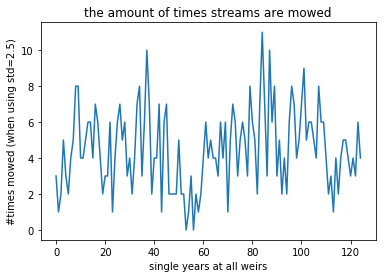

mowing count mode0    4
dtype: int64average is 4.504


In [14]:
df_mow_count = pd.DataFrame.from_dict(mowing_times_counts_yearly.items())#, columns=['weir', 'mowing_count'])
df_mow_count.set_axis(['weir', 'mow_count'], axis=1, inplace=True)

plt.plot(df_mow_count.index.values, df_mow_count['mow_count'])
plt.title('the amount of times streams are mowed')
plt.xlabel('single years at all weirs')
plt.ylabel('#times mowed (when using std=2.5)')
plt.show()

print('mowing count mode'+ str(df_mow_count['mow_count'].mode())+ 'average is ' + str(np.mean(df_mow_count['mow_count'])))

In [15]:
def show_mowing_dates(data_path, weir, mowing_dates_dict):
    df = pd.read_csv(data_path + weir + '_feature_table.csv')
    mowing_dates = mowing_dates_dict[weir]
    
    
    
    for day in range(len(df)):
        if df['VERSCHIL'][day] <= 0:
            df['VERSCHIL'][day] = 0
    averages = []
    days = [i[:10] for i in df['TIME']]
    df['day'] = days
    for day in df['day'].unique():
        average = np.mean(df[df['day'] == day]['VERSCHIL'])
        averages.append(average)
    
    #print(df['day'][1])
    
    indexes = []
    for d in mowing_dates:
        dd = list(df['day'])
        idx = dd.index(d)
        indexes.append(idx)
    
    plt.plot(averages)
    plt.title('verschil graph with indication of found mowing dates')
    plt.xlabel('day from the start of datacollection')
    plt.ylabel('verschil')
    plt.vlines(indexes, alpha=0.3, ymin = -0.1, ymax= 0.7)


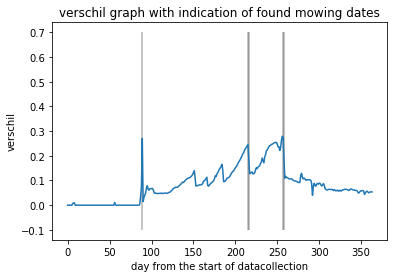

In [16]:
show_mowing_dates(path_yearly, '211N_211M_2020', mowing_dates_dict_yearly)

In [17]:
mowing_dates_dict_yearly['211N_211M_2020'] #This together with the figure above shows that there is an issue with consecutive days

['2020-03-30', '2020-08-05', '2020-08-06', '2020-09-16', '2020-09-17']